In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
images_folder = '/content/drive/MyDrive/sh_Unet2/dataset/train/images'
masks_folder = '/content/drive/MyDrive/sh_Unet2/dataset/train/masks'

In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.jpg')]

for image_file in image_files:
    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)

    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=images_folder, save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 5:  # 원하는 augmentation 수
            break

In [18]:
def generate_and_save_masks(image_files, masks_folder):
    for image_file in image_files:
        img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # Read the image as grayscale
        ret, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  # Create a simple binary mask
        mask_file = os.path.join(masks_folder, os.path.basename(image_file))
        cv2.imwrite(mask_file, mask)

# Get a list of image files in the images folder
image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.jpg')]

# Generate and save masks for all images
generate_and_save_masks(image_files, masks_folder)

In [5]:
for image_file in image_files:
    img = cv2.imread(image_file)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_range = np.array([0, 50, 50])
    upper_range = np.array([10, 255, 255])
    mask = cv2.inRange(hsv_img, lower_range, upper_range)
    mask_file = os.path.join(masks_folder, os.path.basename(image_file).replace('.jpg', '_mask.jpg'))
    cv2.imwrite(mask_file, mask)

In [20]:
# Visualize images and masks
def visualize_images_and_masks(image_files, masks_folder, num_examples=5):
    for i in range(num_examples):
        image_file = image_files[i]
        img = cv2.imread(image_file)
        mask_file = os.path.join(masks_folder, os.path.basename(image_file))
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize images and masks for the first 5 examples
visualize_images_and_masks(image_files, masks_folder, num_examples=5)


Output hidden; open in https://colab.research.google.com to view.

In [25]:
def load_data(images_folder, masks_folder, input_shape):
    image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.jpg')]
    images = []
    masks = []

    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        images.append(img)

        mask_file = os.path.join(masks_folder, os.path.basename(image_file))
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (input_shape[0], input_shape[1]))

        # 이진 클래스로 변환 (0 또는 1로)
        mask = (mask > 0).astype(np.uint8)

        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = masks[..., np.newaxis]
        # '...'은 NumPy 배열에서 슬라이싱 작업을 할 때 사용되는  생략 기호(ellipsis)로 배열의 다른 축을 나타냄
        # '...'를 사용하면 남은 축에 대해서는 모두 유지하면서 슬라이싱이 수행 됨
        # masks = masks[..., np.newaxis]를 실행함으로써 masks 배열의 모양이 (num_samples, height, width, 1)로 변환됨
    masks = to_categorical(masks, num_classes=num_classes, dtype='uint8')  # dtype 추가

    return images, masks

In [26]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Expansive Path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Output layer
    output = Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs, output)
    return model

# 반려견의 색소침착 부위 판별을 위한 U-Net 모델을 최적화하여 성능을 향상시켜보겠습니다. 이를 위해 몇 가지 변경을 가해보겠습니다.

# 입력 이미지 크기 조정: 모델의 성능을 향상시키기 위해 입력 이미지 크기를 늘립니다.
# 더 깊은 네트워크: 더 깊은 네트워크 구조로 모델을 확장하여 특징을 더 잘 추출할 수 있도록 합니다.
# 데이터 확장: 데이터 확장을 통해 학습 데이터를 더 다양하게 만들어 모델의 일반화 능력을 향상시킵니다.
# Batch Normalization: Batch Normalization을 추가하여 학습 안정성을 향상시킵니다.
# Dropout: 일부 레이어에 Dropout을 추가하여 과적합을 방지합니다.

# 위의 코드는 수정된 U-Net 모델로, 입력 이미지 크기가 더 크고 더 깊은 네트워크 구조를 가지며 Batch Normalization과 Dropout 레이어가 추가되었습니다. 이러한 변화로 모델의 성능을 향상시킬 수 있을 것입니다. 데이터셋과 하이퍼파라미터를 조정하여 모델을 더욱 최적화할 수 있습니다.

In [27]:
# 입력 형태와 클래스 개수 정의
input_shape = (256, 256, 3)  # 이미지 차원에 맞게 업데이트
num_classes = 2  # 배경과 객체 포함한 클래스 개수

# 이미지와 마스크 폴더 경로 정의
images_folder = '/content/drive/MyDrive/sh_Unet2/dataset/train/images'
masks_folder = '/content/drive/MyDrive/sh_Unet2/dataset/train/masks'

# 데이터 로드 및 전처리

    # 처음 에러났던 코드 : images, masks = load_data(images_folder, masks_folder, input_shape, num_classes)
    # 에러 : NumPy 배열의 인덱스 오류. to_categorical 함수를 호출하는 부분에서 문제가 발생할 가능성 있음
    # 이진 클래스는 무엇이며 왜 이진클래스로 변환해줘야하는가?
        # 이진 클래스는 두 가지 클래스 중 하나를 나타내는 분류 문제를 의미합니다.
        # 이진 분류는 주로 '예/아니오', '양성/음성'과 같이 두 가지 가능한 결과를 분류하는 문제에 사용됩니다.
        # 여기서의 경우, 이미지의 픽셀 값을 분석하여 해당 픽셀이 "배경" 또는 "객체" 클래스에 속하는지를 결정하는 작업을 수행하려는 것입니다.
        # 따라서 마스크 이미지의 픽셀 값은 배경 또는 객체를 나타내기 위해 이진 형태로 표현됩니다.
        # 원래 to_categorical 함수는 다중 클래스 분류 문제에 사용되며, 클래스 간의 순서를 나타내는 정수 값을 입력으로 받아 원-핫 인코딩된 배열로 변환합니다.
        # 이 경우에는 클래스 간의 순서가 아닌, 픽셀이 배경인지 객체인지를 구별하는 문제이므로, to_categorical 함수는 적절하지 않습니다.
        # 따라서 이진 클래스로 변환하는 것은 각 픽셀의 클래스를 명확히 구분하기 위해 사용하는 것입니다.
        # 배경을 0으로, 객체를 1로 표시하여 각 픽셀의 클래스 정보를 나타내게 됩니다.
        # 이렇게 하면 U-Net과 같은 모델을 사용하여 이미지에서 객체를 정확하게 분할할 수 있게 됩니다.

images, masks = load_data(images_folder, masks_folder, input_shape)
# 데이터셋을 훈련용과 검증용으로 분할
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

In [28]:
# U-Net 모델 생성
model = unet(input_shape, num_classes)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
batch_size = 16
epochs = 50

history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_data=(val_images, val_masks))
    # 위 줄을 실행하고 처음 만났던 오류 : ValueError: Shapes (None, 256, 256, 1) and (None, 256, 256, 2) are incompatible
        # 오류 내용 : 모델의 출력과 목표값의 형태가 일치하지 않음 (모델의 출력은 (None, 256, 256, 1)형태, 목표값의 형태는 (None, 256, 256, 2))
        # 오류 원인 : 마지막 레이어의 출력 클래스 개수와 load_data 함수에서 to_catergorical 함수로 변환한 클래스 개수가 다르기 때문
            # (U Net 모델에서 출력 layer의 class 개수는 'num_classes'와 일치해야 함)
        # how to solve? load_data 함수의 마지막 부분에서 to_catergorical 함수의 'num_calsses' 파라미터를 수정하자. dtype 추가했음

Epoch 1/50
3/3 [==============================] - 30s 2s/step - loss: 0.6071 - accuracy: 0.7380 - val_loss: 3.2450 - val_accuracy: 0.7457
Epoch 2/50
3/3 [==============================] - 1s 259ms/step - loss: 0.3081 - accuracy: 0.8984 - val_loss: 4.7549 - val_accuracy: 0.7441
Epoch 3/50
3/3 [==============================] - 1s 260ms/step - loss: 0.2499 - accuracy: 0.9183 - val_loss: 6.9653 - val_accuracy: 0.7446
Epoch 4/50
3/3 [==============================] - 1s 259ms/step - loss: 0.2101 - accuracy: 0.9212 - val_loss: 252.4285 - val_accuracy: 0.2574
Epoch 5/50
3/3 [==============================] - 1s 259ms/step - loss: 0.2077 - accuracy: 0.9185 - val_loss: 650.0550 - val_accuracy: 0.2565
Epoch 6/50
3/3 [==============================] - 1s 259ms/step - loss: 0.1819 - accuracy: 0.9289 - val_loss: 731.6931 - val_accuracy: 0.2559
Epoch 7/50
3/3 [==============================] - 1s 259ms/step - loss: 0.1917 - accuracy: 0.9214 - val_loss: 836.7424 - val_accuracy: 0.2551
Epoch 8/50
3/3

In [32]:
# 훈련된 모델 저장
model.save('/content/drive/MyDrive/sh_Unet2/models/unet_skin_lesion1.h5')

<ipython-input-31-584e32423434>:18: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from current font.
  plt.tight_layout()
<ipython-input-31-584e32423434>:18: UserWarning: Glyph

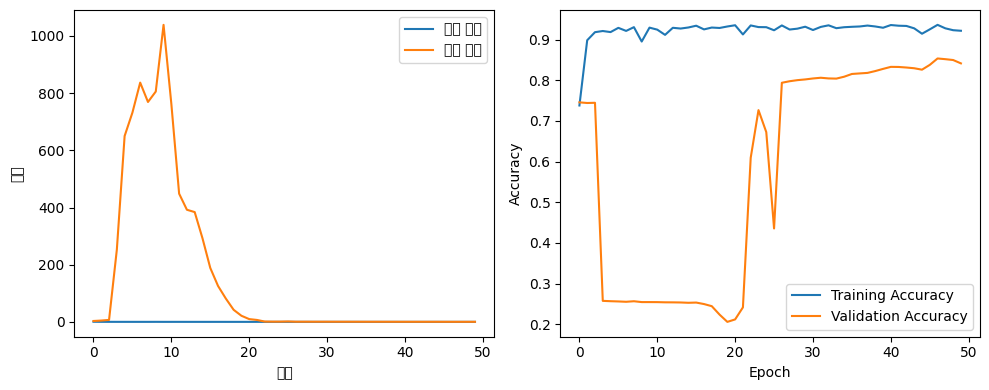

In [31]:
# 훈련 과정 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.xlabel('에폭')
plt.ylabel('손실')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# < 추후에 모델 불러와 테스트하기 >

# import cv2
# import numpy as np
# from tensorflow.keras.models import load_model

# # 저장된 모델 불러오기
# saved_model_path = '/content/drive/MyDrive/sh_Unet2/models/unet_skin_lesion.h5'
# loaded_model = load_model(saved_model_path)

# # 테스트 이미지 불러오기
# test_image_path = '/path/to/your/test/image.jpg'  # 테스트할 이미지의 경로
# test_img = cv2.imread(test_image_path)
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # 이미지 채널 순서 변경

# # 이미지 크기를 모델 입력 형태에 맞게 조정
# input_shape = (256, 256, 3)  # 예시로 설정한 입력 형태
# test_img_resized = cv2.resize(test_img, (input_shape[0], input_shape[1]))

# # 이미지 예측
# predicted_mask = loaded_model.predict(np.expand_dims(test_img_resized, axis=0))

# # 예측 결과를 이진 이미지로 변환 (예측된 클래스 중에서 가장 큰 값을 1로 설정)
# binary_mask = np.argmax(predicted_mask, axis=-1)[0]

# # 결과 시각화
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(test_img)
# plt.title('Test Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(binary_mask, cmap='gray')
# plt.title('Predicted Mask')
# plt.axis('off')

# plt.tight_layout()
# plt.show()